## Getting real data to estimate brazil parameters

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
df = pd.read_csv("brazil_parameters/md_20230731.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [3]:
df["timestamp"] =  df["timestamp"] - df["timestamp"].min()
df["time"] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

In [4]:
import numpy as np
tau0_plus_ = np.array([df[df["ismoplus"]]['time'].unique()])
tau0_minus_ = np.array([df[df["ismominus"]]['time'].unique()])
t_minus_ = np.array([df[df["isjumpplus"]]['time'].unique()])
t_plus_ = np.array([df[df["isjumpminus"]]['time'].unique()])
T_=df["time"].max()

tau0_plus_

array([[   38.838,    38.839,    38.84 , ..., 32485.524, 32485.525,
        32485.526]])

In [6]:
tau0_plus_.shape

(1, 721995)

In [7]:
T_

32485.526

In [8]:
T=T_.max() * 0.01
T

324.85526000000004

In [9]:
tau0_plus_[tau0_plus_ < T].shape

(13710,)

In [10]:
tau0_plus = tau0_plus_[tau0_plus_ < T]
tau0_minus = tau0_minus_[tau0_minus_ < T]
t_minus = t_minus_[t_minus_ < T]
t_plus = t_plus_[t_plus_ < T]

(array([2401., 1383., 1081., 1145., 1481.,  638., 1887.,  912., 1824.,
         958.]),
 array([ 38.838 ,  67.4373,  96.0366, 124.6359, 153.2352, 181.8345,
        210.4338, 239.0331, 267.6324, 296.2317, 324.831 ]),
 <BarContainer object of 10 artists>)

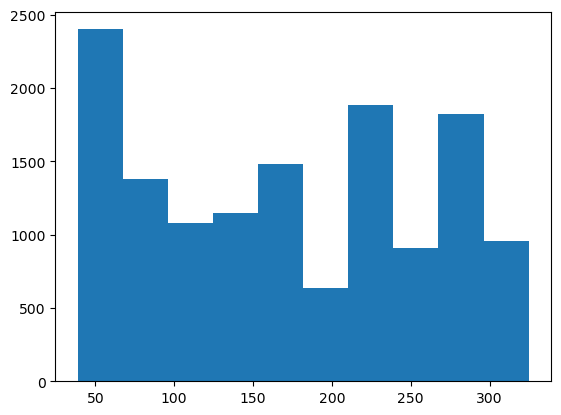

In [11]:
from matplotlib import pyplot as plt
plt.hist(tau0_plus)

(array([1601.,  679.,  334.,  339.,  346.,  178.,  304.,  184.,  260.,
         226.]),
 array([ 38.862,  67.431,  96.   , 124.569, 153.138, 181.707, 210.276,
        238.845, 267.414, 295.983, 324.552]),
 <BarContainer object of 10 artists>)

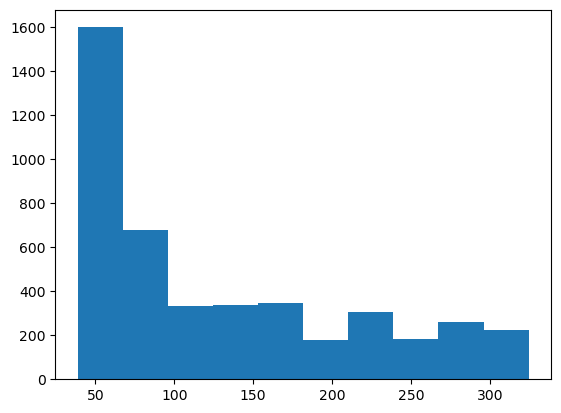

In [12]:
from matplotlib import pyplot as plt
plt.hist(t_plus)

(array([3183., 1789., 1471., 1064., 1485., 1171., 1556., 1061., 1536.,
        1466.]),
 array([ 38.862 ,  67.4532,  96.0444, 124.6356, 153.2268, 181.818 ,
        210.4092, 239.0004, 267.5916, 296.1828, 324.774 ]),
 <BarContainer object of 10 artists>)

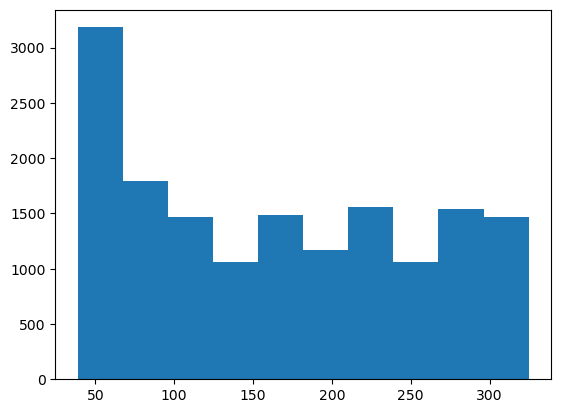

In [13]:
plt.hist(tau0_minus)

(array([1618.,  667.,  367.,  352.,  374.,  147.,  334.,  193.,  274.,
         210.]),
 array([ 38.861 ,  67.4302,  95.9994, 124.5686, 153.1378, 181.707 ,
        210.2762, 238.8454, 267.4146, 295.9838, 324.553 ]),
 <BarContainer object of 10 artists>)

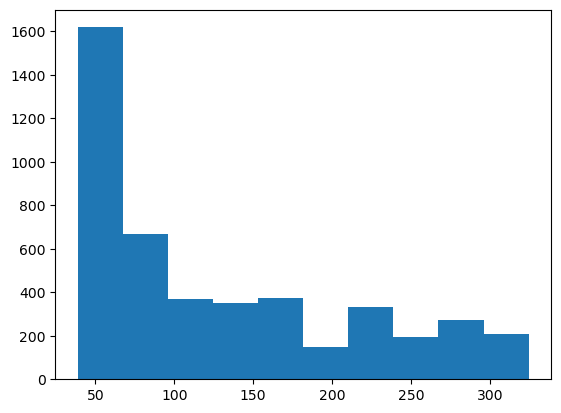

In [14]:
plt.hist(t_minus)

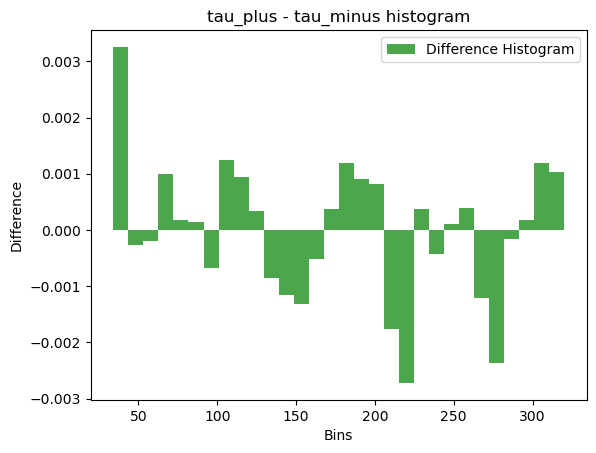

In [15]:
# Create histograms for each dataset
hist1, edges1 = np.histogram(tau0_plus, bins=30, density=True)
hist2, edges2 = np.histogram(tau0_minus, bins=30, density=True)

# Calculate the difference between the histograms
hist_difference = hist2 - hist1

# Plot the difference histogram
plt.bar(edges1[:-1], hist_difference, width=np.diff(edges1), alpha=0.7, color='green', label='Difference Histogram')

# Add labels and legend
plt.xlabel('Bins')
plt.ylabel('Difference')
plt.title('tau_plus - tau_minus histogram')
plt.legend()

# Show the plot
plt.show()

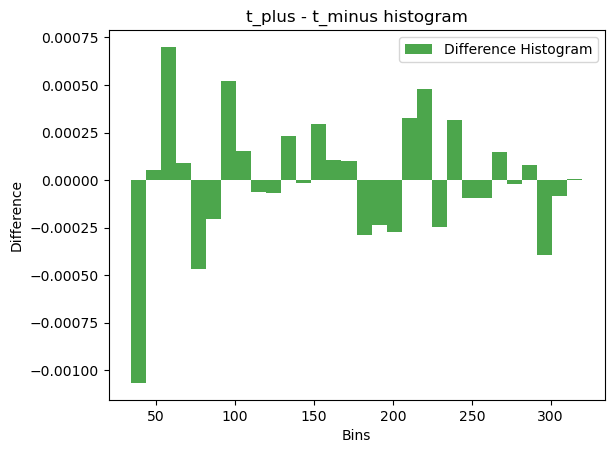

In [16]:
# Create histograms for each dataset
hist1, edges1 = np.histogram(t_plus, bins=30, density=True)
hist2, edges2 = np.histogram(t_minus, bins=30, density=True)

# Calculate the difference between the histograms
hist_difference = hist2 - hist1

# Plot the difference histogram
plt.bar(edges1[:-1], hist_difference, width=np.diff(edges1), alpha=0.7, color='green', label='Difference Histogram')

# Add labels and legend
plt.xlabel('Bins')
plt.ylabel('Difference')
plt.title('t_plus - t_minus histogram')
plt.legend()

# Show the plot
plt.show()

In [17]:
# l = 20000
# tau0_plus = tau0_plus_[:,:l]
# tau0_minus = tau0_minus_[:,:l]
# t_minus = t_minus_[:,:l]
# t_plus = t_plus_[:,:l]

In [18]:
import numpy as np
t_ = df["time"].diff()
dt_min = t_[t_!=0.0].min()
dt_min

0.000999999996565748

In [19]:
import numpy as np
from scipy.optimize import minimize
from scipy import optimize
from likelihood import MaximumLikelihood


def likelihood_to_minimize(y=None,x=None, k=200, theta=0.1):
    bad_result = np.nan #
    if y is not None:
        x=np.array([y[0], y[1], y[1], y[2]])
        bad_result = 1000 # 
    if np.abs(x[1]-x[2]) >20:
        return bad_result
    if x[0]<0 or x[1]<0 or x[2]<0 or x[3]<0:
        return bad_result
    if x[0]>1500 or x[1]>1500 or x[2]>1500 or x[3]>1500:
        return bad_result
    m = MaximumLikelihood(
        T,
        np.array([tau0_plus]),
        np.array([tau0_minus]),
        np.array([t_plus]),
        np.array([t_minus])
    )
    m = m.likelihood_to_minimize(x)/l/1000
    if np.isnan(m) or np.isinf(m):
        m = 1000
    print(m)
    return m

In [20]:

x0 = np.array([10, 100, 1])  # the 4 parameters to optimize
bounds = [(1, 500), (1, 200),(0, 1)]
res = minimize(likelihood_to_minimize, x0, method='BFGS',#
               #bounds=bounds,
               options={'disp': True, 
                        # 'maxiter':1000, "maxfun":2000
                        },
               )
# res = optimize.fmin_cobyla(m.likelihood_to_minimize, x0, cons=[], args=(), maxfun=100000,)
# optimize.differential_evolution(m.likelihood_to_minimize, bounds, args=(), strategy='rand1exp', maxiter=10000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=False, polish=True, init='latinhypercube', atol=0, updating='immediate', workers=1, constraints=(), x0=None,)

print(res)

KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy import optimize
from likelihood import MaximumLikelihood

# def multi_objective_function(x):
#     return [objective_function1(x), objective_function2(x)]
x0 = np.array([10, 100, 1])  # the 4 parameters to optimize
bounds = [(1, 500), (1, 200),(0, 1)]
res = minimize(likelihood_to_minimize, x0, method='Nelder-Mead',#
               bounds=bounds,
               options={'disp': True, 
                        # 'maxiter':1000, "maxfun":2000
                        },
               )
# res = optimize.fmin_cobyla(m.likelihood_to_minimize, x0, cons=[], args=(), maxfun=100000,)
# optimize.differential_evolution(m.likelihood_to_minimize, bounds, args=(), strategy='rand1exp', maxiter=10000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=False, polish=True, init='latinhypercube', atol=0, updating='immediate', workers=1, constraints=(), x0=None,)

print(res)

KeyboardInterrupt: 

-0.04844074210226284
0.017833537615296415


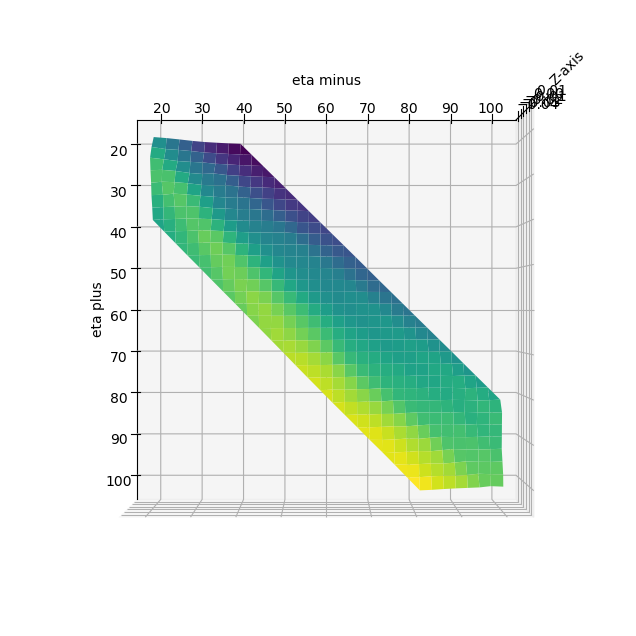

In [ ]:
z_min, z_max = np.nanmin(z), np.nanmax(z)
print(z_min)
print(z_max)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')
ax.view_init(elev=90, azim=00)
# Add labels
ax.set_xlabel('eta plus')
ax.set_ylabel('eta minus')
ax.set_zlabel('Z-axis')

# ax.scatter(x_min, y_min, z_min, color='red', marker='o', s=100, label='Minimum Point')

# Show the plot
plt.show()